In [ ]:
from google.colab import output

In [ ]:
!pip install deap
output.clear()

In [1]:
import os
import sys
import time
import glob
import json
import pytz
import numpy as np
import logging
import seaborn as sns
import argparse
import datetime
import networkx as nx
import matplotlib.pyplot as plt

import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々
import torch.backends.cudnn as cudnn

In [ ]:
import deap
from deap import base, creator
import random
from deap import tools

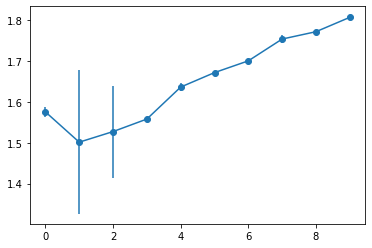

In [3]:

import numpy as np
import matplotlib.pyplot as plt

# example data
y = np.array([1.57536,
1.5013,
1.5272,
1.55782,
1.63604,
1.67141,
1.70013,
1.75342,
1.77137,
1.80652])
x = np.arange(10)
# example error bar values that vary with x-position
error = np.array([0.0130817,
0.175406,
0.112434,
0.00253394,
0.00998286,
0.00100996,
0.00176036,
0.00946255,
0.00398676,
0.00265762,
])
# error bar values w/ different -/+ errors
# lower_error = 0.4 * error
# upper_error = error
# asymmetric_error = [lower_error, upper_error]

# fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
plt.errorbar(x, y, yerr=error, fmt='-o')
# plt.plot(x, y)
# plt.title('variable, symmetric error')

plt.show()

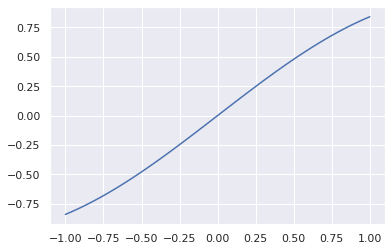

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

x = np.linspace(-1, 1, 100)
y = np.sin(x)
sns.set()
plt.plot(x, y)
plt.show()

In [ ]:

toolbox = base.Toolbox()
# individual
toolbox.register("attribute", random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                toolbox.attribute, n=10)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
ind = toolbox.individual()
print(ind)
print(type(ind))
print(ind[0])

[0.834178900888142, 0.5819531295010304, 0.2859860202327559, 0.1755124229806454, 0.2894500034984746, 0.09503586768366001, 0.3521540695889087, 0.7028306348514758, 0.7027792934020513, 0.6371566274413817]
<class 'deap.creator.Individual'>
0.834178900888142


In [ ]:
class GA():
  
  GENERATION = 40
  POPULATION = 50

  CROSSOVER = 0.5
  MUTATION = 0.2
  TOURNAMENT = 3
  
  def __init__(self):
    # class
    if not hasattr(creator, "FitnessMin"):
      creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
      creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    # individual
    toolbox.register("attribute", random.random)
    toolbox.register("individual", tools.initRepeat, creator.Individual,
                    toolbox.attribute, n=10)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # ops
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=self.TOURNAMENT)
    toolbox.register("evaluate", self.evaluate)
    self.toolbox = toolbox

    # stats
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    self.stats = stats

    self.logbook = tools.Logbook()
    self.logbook.header = "gen", "avg", "min", "hall"

    self.hall = tools.HallOfFame(1)

  def evaluate(self, individual):
    return sum(individual),

  def run(self):
    toolbox = self.toolbox
    stats = self.stats

    pop = toolbox.population(n=self.POPULATION)
    CXPB, MUTPB, NGEN = self.CROSSOVER, self.MUTATION, self.GENERATION

    # Evaluate the entire population
    fitnesses = map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
      ind.fitness.values = fit

    for g in range(NGEN):

      # model learning

      # Select the next generation individuals
      offspring = toolbox.select(pop, len(pop))
      # Clone the selected individuals
      offspring = list(map(toolbox.clone, offspring))

      # Apply crossover and mutation on the offspring
      for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
          toolbox.mate(child1, child2)
          del child1.fitness.values
          del child2.fitness.values

      for mutant in offspring:
        if random.random() < MUTPB:
          toolbox.mutate(mutant)
          del mutant.fitness.values

      # Evaluate the individuals with an invalid fitness
      invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
      fitnesses = map(toolbox.evaluate, invalid_ind)
      for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

      # The population is entirely replaced by the offspring
      pop[:] = offspring

      self.hall.update(pop)

      record = stats.compile(pop)
      self.logbook.record(gen=g, hall=self.hall[0], **record)

    return pop, self.logbook


In [ ]:
ga = GA()
_, book = ga.run()
print(book)

gen	avg      	min      	hall                                                                                                                                                                                                                
0  	4.45123  	2.41388  	[0.23758312979099927, 0.11927238836924021, 0.33495684147566307, 0.13441765811205886, 0.320414161631987, 0.15270867701439927, 0.09745269458231443, 0.10884528685904238, 0.14774903266432216, 0.7604782459132016]     
1  	3.83681  	2.33835  	[0.09186360921508685, 0.3584286150085828, 0.15114734601434432, 0.12677788021774583, 0.3455814077099544, 0.573308135166962, 0.02871201421119185, 0.2856393390285278, 0.1577338283942491, 0.21915635455163962]        
2  	3.24567  	0.725418 	[-1.1849483811962926, 0.13414492334334271, 0.03931202468681172, 0.12677788021774583, 0.3455814077099544, 0.573308135166962, 0.02871201421119185, 0.2856393390285278, 0.1577338283942491, 0.21915635455163962]       
3  	2.69037  	-0.398553	[0.3559074287457372, -0.9708

In [ ]:
import random

from deap import base
from deap import creator
from deap import tools

In [ ]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
toolbox = base.Toolbox()
# Attribute generator 
toolbox.register("attr_bool", random.randint, 0, 1)
# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, 100)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [ ]:
def evalOneMax(individual):
    return sum(individual),

In [ ]:
toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
def main():
    pop = toolbox.population(n=300)

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    # CXPB  is the probability with which two individuals
    #       are crossed
    #
    # MUTPB is the probability for mutating an individual
    CXPB, MUTPB = 0.5, 0.2

    # Extracting all the fitnesses of 
    fits = [ind.fitness.values[0] for ind in pop]

    # Variable keeping track of the number of generations
    g = 0
    
    # Begin the evolution
    while max(fits) < 100 and g < 1000:
        # A new generation
        g = g + 1
        print("-- Generation %i --" % g)


        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        pop[:] = offspring

        # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values[0] for ind in pop]
        
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        
        print("  Min %s" % min(fits))
        print("  Max %s" % max(fits))
        print("  Avg %s" % mean)
        print("  Std %s" % std)

In [ ]:
main()

In [ ]:
tools.initRepeat(list, random.random, 10)

[0.7622855979810815,
 0.3071561622765777,
 0.8939753366262622,
 0.17504609733851662,
 0.37530226872470984,
 0.022732355012931582,
 0.4386029930494567,
 0.9492883746843288,
 0.2018514354270623,
 0.07538157148286795]